<a href="https://colab.research.google.com/github/podobongbong/the_project/blob/main/nov25_LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/podobongbong/the_project.git
import os
os.chdir('/content/the_project')
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Cloning into 'the_project'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 261 (delta 98), reused 45 (delta 45), pack-reused 109 (from 1)
Receiving objects: 100% (261/261), 10.17 MiB | 6.39 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Mounted at /content/drive


In [2]:
!pip install rasterio
!pip install pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.3 MB/s eta 0:00:00


In [3]:
seoul = pd.read_csv('/content/the_project/data/seoul_04_final.csv')
busan = pd.read_csv('/content/the_project/data/busan_04_final.csv')


Seoul Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ym               240 non-null    object 
 1   average          240 non-null    float64
 2   low              240 non-null    float64
 3   high             240 non-null    float64
 4   temp_range       240 non-null    float64
 5   high_deviation   240 non-null    float64
 6   low_deviation    240 non-null    float64
 7   climate_summary  240 non-null    float64
 8   percipitation    240 non-null    float64
 9   energy           240 non-null    int64  
 10  pop              240 non-null    int64  
 11  urban_bcr        240 non-null    float64
 12  urban_far        240 non-null    float64
dtypes: float64(10), int64(2), object(1)
memory usage: 24.5+ KB
None
          average         low        high  temp_range  high_deviation  \
count  240.000000  240.000000  240.000000  240.0000

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


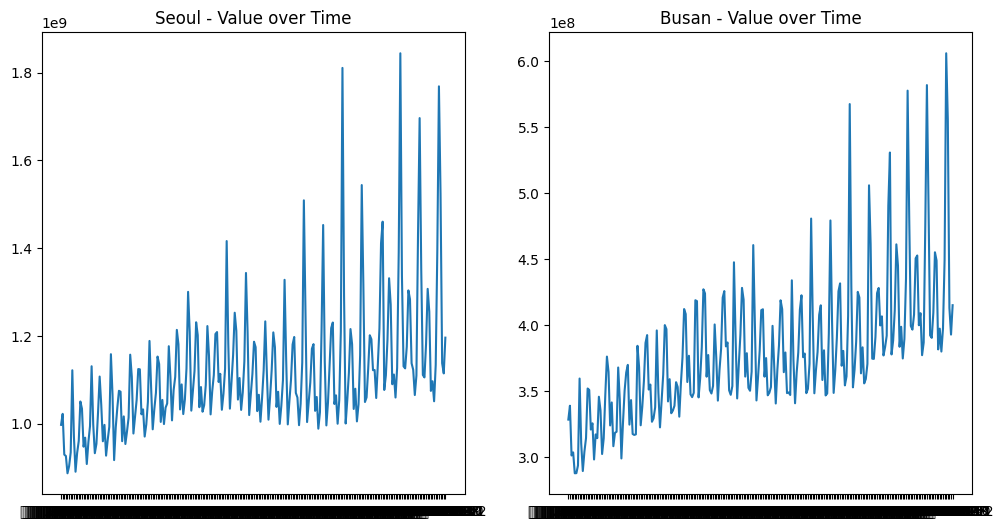


Missing Values (Seoul):
 ym                 0
average            0
low                0
high               0
temp_range         0
high_deviation     0
low_deviation      0
climate_summary    0
percipitation      0
energy             0
pop                0
urban_bcr          0
urban_far          0
dtype: int64

Missing Values (Busan):
 ym                 0
average            0
low                0
high               0
temp_range         0
high_deviation     0
low_deviation      0
climate_summary    0
percipitation      0
energy             0
pop                0
urban_bcr          0
urban_far          0
dtype: int64


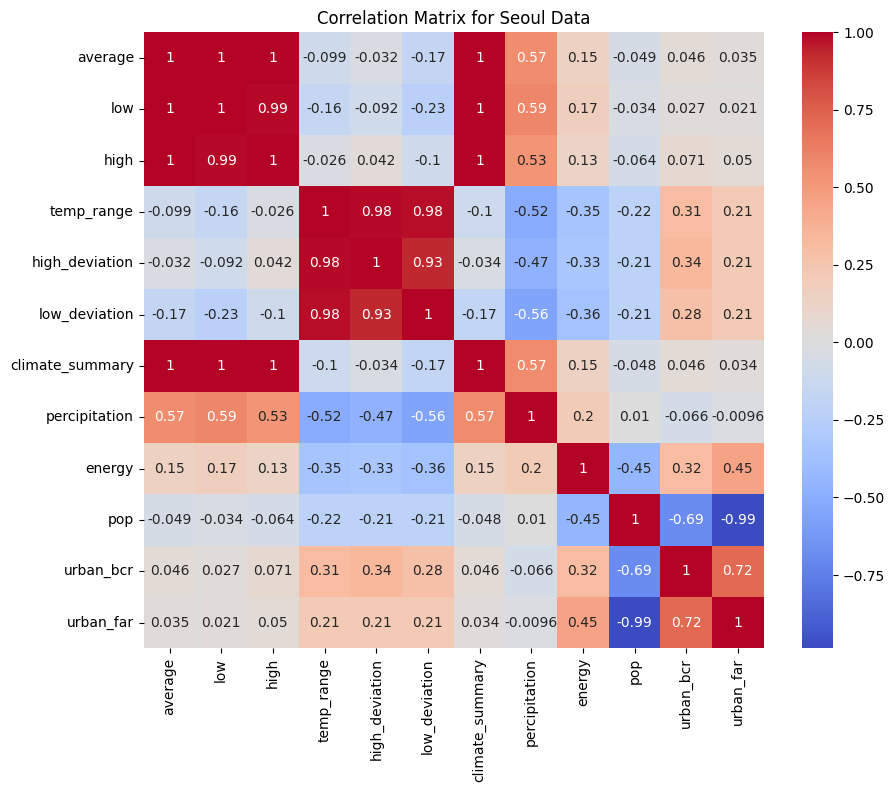

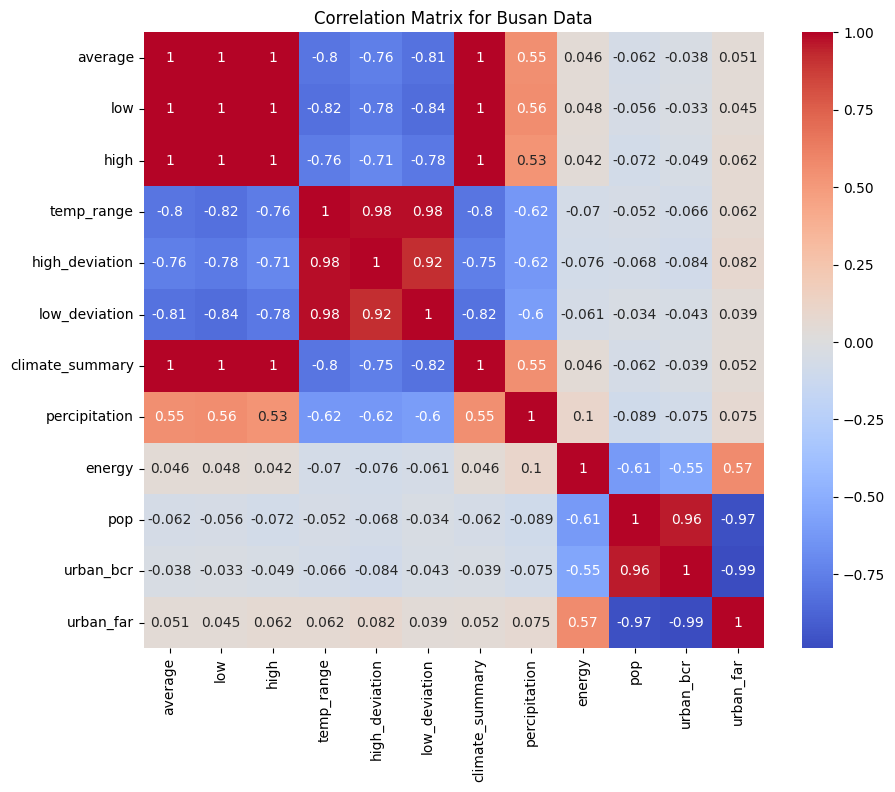

In [4]:
#Exploratory Data Analysis

# prompt: EDA seoul and busan dataset

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Basic EDA
print("Seoul Data:")
print(seoul.info())
print(seoul.describe())
print("\nBusan Data:")
print(busan.info())
print(busan.describe())

# Visualizations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Seoul - Value over Time')
plt.plot(seoul['ym'], seoul['energy'])  # Replace 'value' with your target column
plt.subplot(1, 2, 2)
plt.title('Busan - Value over Time')
plt.plot(busan['ym'], busan['energy']) # Replace 'value' with your target column
plt.show()


# Check for missing values
print("\nMissing Values (Seoul):\n", seoul.isnull().sum())
print("\nMissing Values (Busan):\n", busan.isnull().sum())

# Correlation matrix
var = [col for col in seoul.columns if col != 'ym']
correlation = seoul[var].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Seoul Data')
plt.show()

correlation = busan[var].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Busan Data')
plt.show()



In [5]:
seoul['ym'] = pd.to_datetime(seoul['ym'])
busan['ym'] = pd.to_datetime(busan['ym'])

# Filter dataframes to start from 2008
seoul = seoul[seoul['ym'].dt.year >= 2008]
busan = busan[busan['ym'].dt.year >= 2008]


<ipython-input-5-3118db5255a9>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seoul['ym'] = pd.to_datetime(seoul['ym'])
<ipython-input-5-3118db5255a9>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  busan['ym'] = pd.to_datetime(busan['ym'])


In [11]:

# General libraries
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# TensorFlow and Keras
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, concatenate, Reshape, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

import numpy as np



# GIS-specific libraries
import rasterio
from PIL import Image

# seed fixing
seed = random.randint(0, 100000) # generate a random seed
print(f"Seed used for this run: {seed}")
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

#%% DATA PREP
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Seoul Scalers
scaler_energy_seoul = MinMaxScaler()
scaler_population_seoul = MinMaxScaler()
scaler_climate_avg_seoul = MinMaxScaler()
scaler_climate_per_seoul = MinMaxScaler()

# Busan Scalesrs
scaler_energy_busan = MinMaxScaler()
scaler_population_busan = MinMaxScaler()
scaler_climate_avg_busan = MinMaxScaler()
scaler_climate_per_busan = MinMaxScaler()

# Normalize Seoul data (energy, pop, climate, urban 2)
seoul_energy_scaled = scaler_energy_seoul.fit_transform(seoul['energy'].values.flatten().reshape(-1, 1))
seoul_population_scaled = scaler_population_seoul.fit_transform(seoul['pop'].values.flatten().reshape(-1, 1))
seoul_climate_avg_scaled = scaler_climate_avg_seoul.fit_transform(seoul['average'].values.flatten().reshape(-1, 1))
seoul_climate_per_scaled = scaler_climate_per_seoul.fit_transform(seoul['percipitation'].values.flatten().reshape(-1, 1))

# Normalize Busan data (energy, pop, climate, urban 2)
busan_energy_scaled = scaler_energy_busan.fit_transform(busan['energy'].values.flatten().reshape(-1, 1))
busan_population_scaled = scaler_population_busan.fit_transform(busan['pop'].values.flatten().reshape(-1, 1))
busan_climate_avg_scaled = scaler_climate_avg_busan.fit_transform(busan['average'].values.flatten().reshape(-1, 1))
busan_climate_per_scaled = scaler_climate_per_busan.fit_transform(busan['percipitation'].values.flatten().reshape(-1, 1))

# sin,cos
#sin = seoul['sin'].values.flatten().reshape(-1,1)
#cos = seoul['cos'].values.flatten().reshape(-1,1)

Seed used for this run: 47955


In [8]:
#%% SLIDING WINDOW
#%% Create Sliding Windows
def create_sliding_window_multi(data_energy, data_population, data_climate_avg, data_climate_per, window_size):
    X, y = [], []
    for i in range(window_size, len(data_energy)):
        X.append(np.column_stack((data_energy[i-window_size:i], data_population[i-window_size:i]
                                  ,data_climate_avg[i-window_size:i], data_climate_per[i-window_size:i])))
        y.append(data_energy[i])  # Next month's energy consumption
    return np.array(X), np.array(y)

WINDOW_SIZE = 12
feature_number = 4 #energy, population, average temperature, percipitation

# Create sliding window samples for Seoul and Busan
X_seoul, y_seoul = create_sliding_window_multi(seoul_energy_scaled, seoul_population_scaled
                                               , seoul_climate_avg_scaled, seoul_climate_per_scaled, WINDOW_SIZE)
X_busan, y_busan = create_sliding_window_multi(busan_energy_scaled, busan_population_scaled
                                               , busan_climate_avg_scaled, busan_climate_per_scaled, WINDOW_SIZE)

# Split Busan data into training and test sets (hold out the last 12 months for testing)
X_train_busan = X_busan[:-12]
y_train_busan = y_busan[:-12]
X_test_busan = X_busan[-12:]
y_test_busan = y_busan[-12:]


In [17]:
# Load and preprocess GIS images

def load_and_preprocess_tif(file_path, target_size=(256, 256)):
    # Open TIF file
    with rasterio.open(file_path) as src:
        data = src.read()  # Read all bands

    # Reshape to (height, width, channels)
    data = np.transpose(data, (1, 2, 0))

    # If the image has fewer than 3 channels, stack it to 3 channels
    if data.shape[2] < 3:
        # Repeat the last channel to create a 3-channel image
        # (or you might need a different strategy depending on the data)
        data = np.dstack((data, data[:, :, -1]))

    # Normalize to range [0, 1]
    data = data / np.max(data)

    # Resize to target size
    img = Image.fromarray((data * 255).astype(np.uint8))
    img = img.resize(target_size)
    img = np.array(img) / 255.0

    return img


# Example: Load TIF images for Seoul and Busan
gis_image_seoul = load_and_preprocess_tif('/content/the_project/data/gis/seoul_ntl_export.tif')
gis_image_busan = load_and_preprocess_tif('/content/the_project/data/gis/busan_ntl_export.tif')

# Expand dimensions to match CNN input format
gis_image_seoul = np.expand_dims(gis_image_seoul, axis=0)  # Shape: (1, 256, 256, channels)
gis_image_busan = np.expand_dims(gis_image_busan, axis=0)  # Shape: (1, 256, 256, channels)


In [18]:
# Sequential input (LSTM)
seq_input = Input(shape=(WINDOW_SIZE, feature_number), name='Sequential_Input')
lstm_out = LSTM(64, activation='tanh', name='LSTM_Layer')(seq_input)

# GIS input (CNN)
img_input = Input(shape=(256, 256, 3), name='Image_Input')
cnn = Conv2D(32, (3, 3), activation='relu', name='Conv1')(img_input)
cnn = MaxPooling2D((2, 2), name='Pool1')(cnn)
cnn = Conv2D(64, (3, 3), activation='relu', name='Conv2')(cnn)
cnn = MaxPooling2D((2, 2), name='Pool2')(cnn)
cnn = Flatten(name='Flatten')(cnn)

# Combine LSTM and CNN outputs
merged = concatenate([lstm_out, cnn], name='Concatenate')
dense_1 = Dense(64, activation='relu', name='Dense_Combined_1')(merged)
batch_norm = BatchNormalization(name='Batch_Norm')(dense_1)
output = Dense(1, activation='linear', name='Output')(batch_norm)

# Build model
base_model = Model(inputs=[seq_input, img_input], outputs=output)
base_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
base_model.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 254, 254, 32)   │            896 │ Image_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool1 (MaxPooling2D)      │ (None, 127, 127, 32)   │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 125, 125, 64)   │         18,496 │ Pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Sequential_Input          │ (None, 12, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool2 (MaxPooling2D)      │ (None, 62, 62, 64)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM_Layer (LSTM)         │ (None, 64)             │         17,664 │ Sequential_Input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Flatten (Flatten)         │ (None, 246016)         │              0 │ Pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Concatenate (Concatenate) │ (None, 246080)         │              0 │ LSTM_Layer[0][0],      │
│                           │                        │                │ Flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense_Combined_1 (Dense)  │ (None, 64)             │     15,749,184 │ Concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Batch_Norm                │ (None, 64)             │            256 │ Dense_Combined_1[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output (Dense)            │ (None, 1)              │             65 │ Batch_Norm[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,786,561 (60.22 MB)

 Trainable params: 15,786,433 (60.22 MB)

 Non-trainable params: 128 (512.00 B)

In [19]:
# Pretraining the base model on Seoul data
print("Pretraining on Seoul's data...")
history_pretrain = base_model.fit(
    [X_seoul, np.repeat(gis_image_seoul, len(X_seoul), axis=0)],  # Pair sequential data with GIS image
    y_seoul,
    epochs=100,
    batch_size=16,
    validation_split=0.2
)

# Freeze LSTM and CNN layers for feature extraction
base_model.get_layer('LSTM_Layer').trainable = False
base_model.get_layer('Conv1').trainable = False
base_model.get_layer('Conv2').trainable = False


Pretraining on Seoul's data...
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0564 - mae: 0.1756 - val_loss: 1.0930 - val_mae: 1.0209
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0312 - mae: 0.1253 - val_loss: 9.9739 - val_mae: 3.1501
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0225 - mae: 0.1002 - val_loss: 16.0867 - val_mae: 4.0045
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0217 - mae: 0.1072 - val_loss: 13.7140 - val_mae: 3.6964
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0201 - mae: 0.1032 - val_loss: 15.4560 - val_mae: 3.9250
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0194 - mae: 0.0950 - val_loss: 14.9519 - val_mae: 3.8603
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0186 - mae: 0.0899 - val_loss: 30.6006 - val_mae: 5.5273
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0177 - mae: 0.0883 - val_loss: 72.4524 - val_mae: 8.5090
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━

In [20]:
# Feature extractor from pretrained base model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('Concatenate').output)

# Extract features from Busan data
X_train_features_busan = feature_extractor.predict([X_train_busan, np.repeat(gis_image_busan, len(X_train_busan), axis=0)])
X_test_features_busan = feature_extractor.predict([X_test_busan, np.repeat(gis_image_busan, len(X_test_busan), axis=0)])

# Fine-tuning model
input_features_layer = Input(shape=(X_train_features_busan.shape[1],), name='Input_Features')
reshaped_input = Reshape((1, X_train_features_busan.shape[1]))(input_features_layer)
lstm_new = LSTM(32, activation='tanh', name='LSTM_New')(reshaped_input)

dense_new_1 = Dense(32, activation='relu', name='Dense_New_1')(lstm_new)
batch_norm_1 = BatchNormalization(name='Batch_Norm_1')(dense_new_1)
dense_new_2 = Dense(16, activation='relu', name='Dense_New_2')(batch_norm_1)
batch_norm_2 = BatchNormalization(name='Batch_Norm_2')(dense_new_2)
output_new_layer = Dense(1, activation='linear', name='Output')(batch_norm_2)

fine_tuned_model = Model(inputs=input_features_layer, outputs=output_new_layer)
fine_tuned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])


4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [21]:
# Fine-tune on Busan data
print("Fine-tuning on Busan's data...")
history_finetune = fine_tuned_model.fit(
    X_train_features_busan, y_train_busan,
    epochs=100,
    batch_size=32,
    validation_split=0.2
)

# Check weights after fine-tuning
print("Weights after fine-tuning:")
print(fine_tuned_model.weights)


Fine-tuning on Busan's data...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - loss: 0.0687 - mae: 0.2175 - val_loss: 0.0767 - val_mae: 0.1988
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0575 - mae: 0.2126 - val_loss: 0.0633 - val_mae: 0.1654
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0513 - mae: 0.2086 - val_loss: 0.0435 - val_mae: 0.1360
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0481 - mae: 0.2055 - val_loss: 0.0375 - val_mae: 0.1495
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0457 - mae: 0.2024 - val_loss: 0.0377 - val_mae: 0.1618
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0438 - mae: 0.1993 - val_loss: 0.0402 - val_mae: 0.1729
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0424 - mae: 0.1962 - val_loss: 0.0431 - val_mae: 0.1815
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0410 - mae: 0.1932 - val_loss: 0.0469 - val_mae: 0.1920
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 

Evaluating on Busan's test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.6436 - mae: 2.3665
Test Loss: 5.643595218658447, Test MAE: 2.366525650024414


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


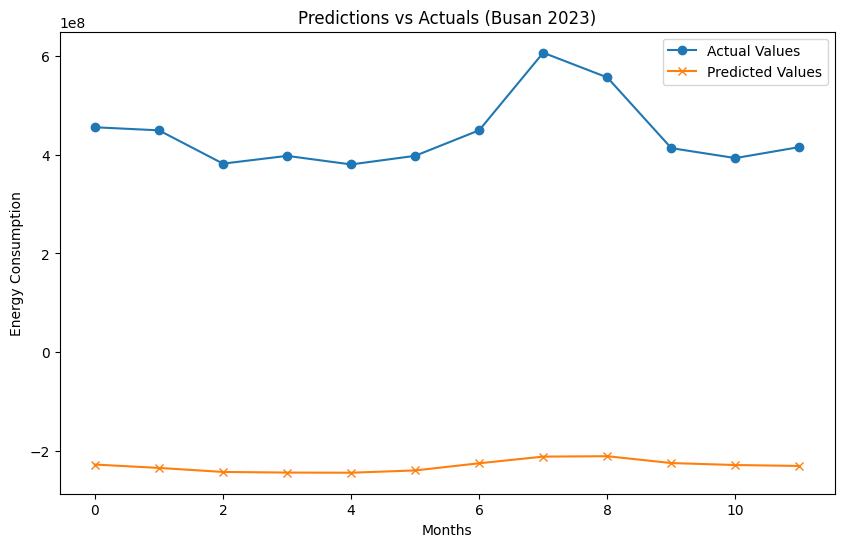

In [22]:

# Step 6: Evaluate and Predict on Busan's Test Data

print("Evaluating on Busan's test data...")
test_loss, test_mae = fine_tuned_model.evaluate(X_test_features_busan, y_test_busan)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict on test data
predictions = fine_tuned_model.predict(X_test_features_busan)

# Rescale predictions and actual values back to the original scale for interpretation
predictions_rescaled = scaler_energy_busan.inverse_transform(predictions.reshape(-1, 1)).flatten()
actual_rescaled = scaler_energy_busan.inverse_transform(y_test_busan.reshape(-1, 1)).flatten()

# Visualization of Prediction Results
def plot_predictions(y_true, y_pred, title='Predictions vs Actuals (Busan 2023)'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

plot_predictions(actual_rescaled, predictions_rescaled)

In [ ]:


# Base model: LSTM
## Step 1: Pre-trained Model for Feature Extraction on Seoul's Data
# Building and compiling the pre-trained model
input_layer = Input(shape=(WINDOW_SIZE, feature_number), name='Input')
lstm_out = LSTM(64, activation='tanh', name='LSTM_Layer')(input_layer)
dense_1 = Dense(32, activation='relu', name='Dense_1')(lstm_out)
dense_2 = Dense(16, activation='relu', name='Dense_2')(dense_1)
output_layer = Dense(1, activation='linear', name='Output')(dense_2)

pretrained_model = Model(inputs=input_layer, outputs=output_layer)
pretrained_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Pretrain on Seoul's data
print("Pretraining on Seoul's data...")
history_pretrain = pretrained_model.fit(X_seoul, y_seoul, epochs=100, batch_size=16, validation_split=0.2)

# Check weights before freezing
print("Weights before freezing:")
print(pretrained_model.weights)

pretrained_model.summary()


In [ ]:
# Hyperparameter grid for tuning
param_grid = {
    'lstm_units': [32, 64, 128], #LSTM의 셀 수. 학습할수 있는 feature의 차원을 결정. 많으면 복잡 시퀀스 학습 가능/비용부담+과적합 위험
    'dense1_units': [16, 32, 64], #Dense1의 뉴런 수. LSTM이 추출한 시퀀스를 압축, 변환. 많으면 복잡 비선형 관계 학습 가능/
    'dense2_units': [8, 16, 32], #Dense2의 뉴런 수. Dense1을 추가 압축, 변환.
    'learning_rate': [0.001, 0.0005, 0.0001], #가중치를 업데이트 하는 속도. 컴퓨팅 효율화
    'batch_size': [16, 32] # 한번에 모델에 입력되는 샘플 사이즈. 작을수록 세밀/비용부담, 컴퓨팅 효율화
}

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Initialize trackers for the best model
best_model = None
best_val_loss = float('inf')
best_params = None

# Perform grid search over parameter combinations
for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")

    # Build model with current parameters
    input_layer = Input(shape=(WINDOW_SIZE, feature_number), name='Input')
    lstm_out = LSTM(params['lstm_units'], activation='tanh', name='LSTM_Layer')(input_layer)
    dense_1 = Dense(params['dense1_units'], activation='relu', name='Dense_1')(lstm_out)
    dense_2 = Dense(params['dense2_units'], activation='relu', name='Dense_2')(dense_1)
    output_layer = Dense(1, activation='linear', name='Output')(dense_2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(
        X_seoul, y_seoul,
        epochs=100,
        batch_size=params['batch_size'],
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate the model on validation data
    val_loss = min(history.history['val_loss'])
    print(f"Validation Loss: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_params = params

# Display the best parameters and validation loss
print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_val_loss)

# Save the best model for future use
best_model.save('best_pretrained_model.h5')
print("Best model saved as 'best_pretrained_model.h5'.")

# Load the best model if needed
# from tensorflow.keras.models import load_model
# best_model = load_model('best_pretrained_model.h5')


In [ ]:
pretrained_model = best_model
## Step 3: Freeze the LSTM layer for Feature Extraction
#전략: 데이터셋 작으면 최대한 많이 freezing, 데이터셋 크고 원래 도메인과 다르다면 많이 조정.

#Option 1: only freezing LSTM Layer: LSTM레이어는 시간적 패턴 학습 특화. 시간에 따른 에너지 소비의 일반적 패턴을 서울에서 학습, 부산 데이터에 활용.
# Freeze the LSTM layer in the pre-trained model for feature extraction
pretrained_model.get_layer('LSTM_Layer').trainable = False

# Confirm frozen layers
print("Layers after freezing:")
for layer in pretrained_model.layers:
    print(layer.name, layer.trainable)

# Create a model for feature extraction from the LSTM layer's output
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('LSTM_Layer').output)

# Generate extracted features for Busan's training and test data
X_train_features_busan = feature_extractor.predict(X_train_busan)
X_test_features_busan = feature_extractor.predict(X_test_busan)


In [ ]:

## Step 4: Build a New Model for Fine-Tuning on Busan's Data
# New model input layer
input_features_layer = Input(shape=(X_train_features_busan.shape[1],), name='Input_Features')
reshaped_input = Reshape((1, X_train_features_busan.shape[1]))(input_features_layer)  # Reshape to (batch_size, time_steps=1, features)

# New LSTM layer for fine-tuning
lstm_new = LSTM(32, activation='tanh', name='LSTM_New')(reshaped_input)

# Add dense layers with batch normalization for better training
dense_new_1 = Dense(32, activation='relu', name='Dense_New_1')(lstm_new)
batch_norm_1 = BatchNormalization(name='Batch_Norm_1')(dense_new_1)
dense_new_2 = Dense(16, activation='relu', name='Dense_New_2')(batch_norm_1)
batch_norm_2 = BatchNormalization(name='Batch_Norm_2')(dense_new_2)

# Final output layer
output_new_layer = Dense(1, activation='linear', name='Output')(batch_norm_2)

# Combine into new model
new_model = Model(inputs=input_features_layer, outputs=output_new_layer)
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Check initial weights of new model before fine-tuning
print("Initial weights of the new model:")
print(new_model.weights)



In [ ]:

## Step 5: Train the new model with extracted features for Busan's data
print("Training new layers on Busan's data...")
history_finetune = new_model.fit(X_train_features_busan, y_train_busan, epochs=100, batch_size=32, validation_split=0.2)

# Check weights after fine-tuning
print("Weights after fine-tuning:")
print(new_model.weights)




In [ ]:

# Step 6: Evaluate and Predict on Busan's Test Data

print("Evaluating on Busan's test data...")
test_loss, test_mae = new_model.evaluate(X_test_features_busan, y_test_busan)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict on test data
predictions = new_model.predict(X_test_features_busan)

# Rescale predictions and actual values back to the original scale for interpretation
predictions_rescaled = scaler_energy_busan.inverse_transform(predictions.reshape(-1, 1)).flatten()
actual_rescaled = scaler_energy_busan.inverse_transform(y_test_busan.reshape(-1, 1)).flatten()

# Visualization of Prediction Results
def plot_predictions(y_true, y_pred, title='Predictions vs Actuals (Busan 2023)'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

plot_predictions(actual_rescaled, predictions_rescaled)

In [ ]:

epochs = range(1, len(history_finetune.history['loss']) + 1)

# Loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_finetune.history['loss'], label='Train Loss')
plt.plot(epochs, history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.title('Training and Validation Loss over Epochs')
plt.show()

# MAE
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_finetune.history['mae'], label='Train MAE')
plt.plot(epochs, history_finetune.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(['Train MAE', 'Validation MAE'])
plt.title('Training and Validation MAE over Epochs')
plt.show()


In [ ]:
save_path = "./transfer_LSTM_hybrid_model.h5"
new_model.save(save_path)
print("Model saved at:", save_path)
